In [1]:
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir)

In [2]:
import dump
import numpy as np
from tqdm import tqdm

In [3]:
import Py_FTP_Langevin as ftp

# First time passage simulations

In [4]:
#//! *********** PARAMETERS PARTICLE PROPERTIES *********** !
MM = 28.9647  #;  //! Molecular weight of fluid molecules (kg/kmol)
Rho_p = 1800. #; //! PPs mass density
Dp = 80e-09

#//! *********** SIMULATION PARAMETERS *********** !
N_runs = 1 #;
Box_L_factor_dmax = 1.6 #4 #; //! Box size as factor of D_p
T_g = 1700. #;            //! Fluid temperature
P_g = 101300. #;          //! Fluid pressure
phi_p = 0.01 / 100 #;   //! Particles number concentration (1000 ppm = 0.01)    
with_collisions = True

#//! *********** LANGEVIN PARAMETERS *********** !
run_taus_min = 120 #; // Keep in 100 to be accurate with LD theory (otherwise the 6*D*t is not strictly respected)
LD_dt_factor = 0.001 #;

#//! *********** PARAMETERS INT. POTENTIALS *********** !
A = 2.62e-19    #;    //! Hamaker constant (J) 2.38e-19
s_LJ = 0.35e-09 #5.95e-10 #; //! LJ repulsive form parameter
alpha_dp = 0.01
factor_vdw = 1.05
direct = "/home/jose/Desktop/Gitlab/mitacs/mitacs_project/Python_simulations/aggregates_DLCA";

In [5]:
model = ftp.Pymodel(direct)
model

In [6]:
#model.Set_prop_default()
model.Set_prop(MM,Rho_p,N_runs,Box_L_factor_dmax,
               T_g,P_g,phi_p,run_taus_min,
               LD_dt_factor,A,s_LJ,alpha_dp,factor_vdw,Dp,
               with_collisions,direct)

In [7]:
model.Show_prop()

SIMULATION
run_taus_min:                 120
L_box/R_max                   1.6
phi_p (ppm)                   100
Path                          /home/jose/Desktop/Gitlab/mitacs/mitacs_project/Python_simulations/aggregates_DLCA
alpha_dp                      0.01
factor_vdw                    1.05
with_collisions               1
 
FLUID PROPERTIES
Temperature (K)               1700
Pressure (Pa)                 101300
Viscosity (kg/m*s)            5.66636e-05
Fluid mfp (nm)                489.736
Maxwell avg vel (m/s)         1114.75
 
PARTICLES PROPERTIES          
Particles mean diameter (nm)  80
Hamaker constant A/(k_b*T)    11.1627
Repuls. form param. s_LJ (m)  3.5e-10
Bulk mass density (kg/m^3)    1800
 


In [8]:
ftp.Init_Random()
ftp.Make_output_folder()

In [9]:
files = ftp.get_dir_files(direct)
N_files = len(files)

In [10]:
def Export_current_sim(ftp_model,i,normalize=False):
    x1,y1,z1,r1 = ftp_model.Get_spheres(1)
    x2,y2,z2,r2 = ftp_model.Get_spheres(2)
    ofname = "ovito_out/Simulation_01.dump"
    radius = np.concatenate((r1, r2))
    if (normalize):
        nor_factor = np.mean(radius)
        radius = radius/nor_factor
    box_l = ftp_model.L_box/nor_factor
    box = ((-0.5*box_l,0.5*box_l),\
           (-0.5*box_l,0.5*box_l),\
           (-0.5*box_l,0.5*box_l))
    pos = np.array([np.concatenate((x1/nor_factor, x2/nor_factor)),
                   np.concatenate((y1/nor_factor, y2/nor_factor)),
                   np.concatenate((z1/nor_factor, z2/nor_factor))]).transpose()
    vel = pos *0
    
    N = len(x1)+len(x2)
    dump.writeOutput(ofname, N, i, box, radius=radius, pos=pos, v=vel)
    return

def run(ftp_model, model, n_steps):
    for j in range(n_steps):
        ftp_model.OneRW_step_LD(model)
    return

def isNaN(num):
    if float('-inf') < float(num) < float('inf'):
        return False 
    else:
        return True

In [11]:
i_limit = 500 * 400

d_times = np.asarray([])
t_reses = np.asarray([])
d_ij_mins = np.asarray([])

In [12]:
for k in tqdm(range(1)): #N_files):
    path_agg = direct + "/" + files[k].decode('utf-8')
    print(path_agg)
    ftp_model = ftp.PyFTP(model)
    ftp_model.Load_aggregates_external(path_agg, model)
    #ftp_model.show_spheres()
    #if (k == 0):
    #    ftp.Show_parameters(spheres2, model)
    ftp_model.Move_2_origin()
    for j in range(model.N_runs):
        ftp_model.Random_init_location()
        Export_current_sim(ftp_model,0,True)
        i=1
        it_exp = 1
        collision = False
        while((not collision) and (i<i_limit)):
            collision = ftp_model.run(model, 1)
            #asd_ = ftp_model.run(model, 1)
            d_times = np.append(d_times, ftp_model.d_time())
            t_reses = np.append(t_reses, ftp_model.t_res())
            d_ij_mins = np.append(d_ij_mins, ftp_model.d_ij_min())
            if(isNaN(ftp_model.t_res())):
                print("d_time ",ftp_model.d_time(), " t_res ",ftp_model.t_res())
                break
            if(i%10==0):
                Export_current_sim(ftp_model,it_exp,True)
                it_exp +=1
            i += 1

  0%|                                                                                                                                                                         | 0/1 [00:00<?, ?it/s]

/home/jose/Desktop/Gitlab/mitacs/mitacs_project/Python_simulations/aggregates_DLCA/Jose_MORPHOLOGY_02p6_Dp80nm_np0_3200_test6_only_Epstein_drag_run1_morphology_1442.dat


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [01:38<00:00, 98.60s/it]

Collision detected (moving,static): (42 35); dist/(R_p1+R_p2)= 1.04992


In [13]:
tau = (0.407587e-06)

np.min(d_times[t_reses>0])/tau

0.0029500715292981984

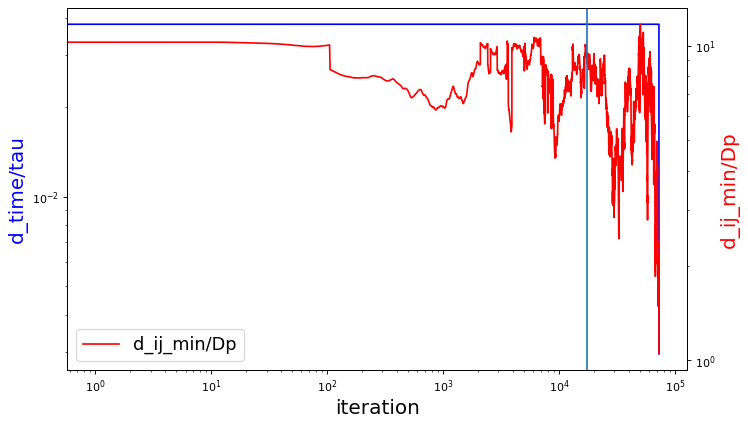

(<matplotlib.legend.Legend at 0x7fc4b9e1e550>, None)

In [14]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(num=None, figsize=(10, 6), dpi=80, facecolor='w', edgecolor='k')
ax2 = ax1.twinx()
ax1.loglog(d_times/tau,"b-",label="d_time/tau")
ax2.loglog(d_ij_mins/Dp,"-r",label="d_ij_min/Dp")
ax1.set_xlabel('iteration', fontsize=18)
ax1.set_ylabel('d_time/tau', fontsize=18, color='b')
ax2.set_ylabel('d_ij_min/Dp', fontsize=18, color='r')
plt.axvline(x=1731*10)
plt.legend(fontsize=16, loc=0), plt.show()

#fig = plt.figure(num=None, figsize=(10, 6), dpi=80, facecolor='w', edgecolor='k');
#fig.set_tight_layout(False)
#plt.loglog(d_ij_mins/Dp, d_times/tau,"-",label="d_times/tau")
#plt.xlabel("d_ij_mins/Dp"); plt.ylabel("d_times/tau")
#plt.yscale("log")
#plt.xlim([2,1e+03])
#plt.legend(fontsize=16, loc=0), plt.show()

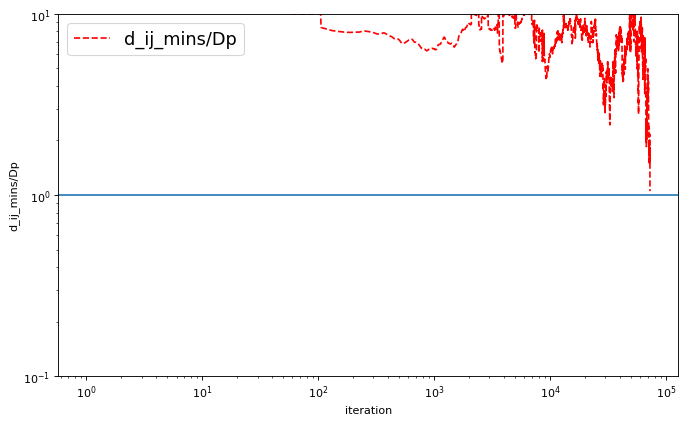

(<matplotlib.legend.Legend at 0x7fc4b95fb730>, None)

In [15]:
fig = plt.figure(num=None, figsize=(10, 6), dpi=80, facecolor='w', edgecolor='k');
fig.set_tight_layout(False)
plt.loglog(d_ij_mins/Dp,"--r",label="d_ij_mins/Dp")
plt.ylabel("d_ij_mins/Dp");
plt.xlabel("iteration")
#plt.yscale("log")
plt.axhline(y=1)
plt.ylim([1e-01,1e+01])
plt.legend(fontsize=16, loc=0), plt.show()

In [16]:
np.min(d_ij_mins)/Dp

1.0499217905891711

In [17]:
ftp_model.d_time()*(1e+06)

0.0012024108044120648

In [18]:
ftp_model.show_spheres()

Particle list properties  
Np (list.size()):         55(55)
Rmax (nm)                 565.624
Rg (nm)                   327.174
Rg/Rp                     8.17936
Rpp_v (nm)                40
mean_Rp (nm)              40
m (fg)                    0.0265402
Kn (-)                    1.49687
tau (us)                  0.407587
d_time (us)               0.000407587
langevin_check            1
f (kg/s)                  6.51153e-11
f_agg/f_pp                30.6743
(x_cm, y_cm, z_cm)        0 0 0
relative_distance         0
F_vdW (N)                 0
F_vdW/F_grav              0
F_vdW/F_point             0
 
Particle list properties  
Np (list.size()):         55(55)
Rmax (nm)                 565.624
Rg (nm)                   327.174
Rg/Rp                     8.17936
Rpp_v (nm)                40
mean_Rp (nm)              40
m (fg)                    0.0265402
Kn (-)                    1.49687
tau (us)                  0.407587
d_time (us)               0.000407587
langevin_check            1


np.min(ft)/fa_ref=  -228.28712000098943 ; fa_ref= 4.487912964807573e-11


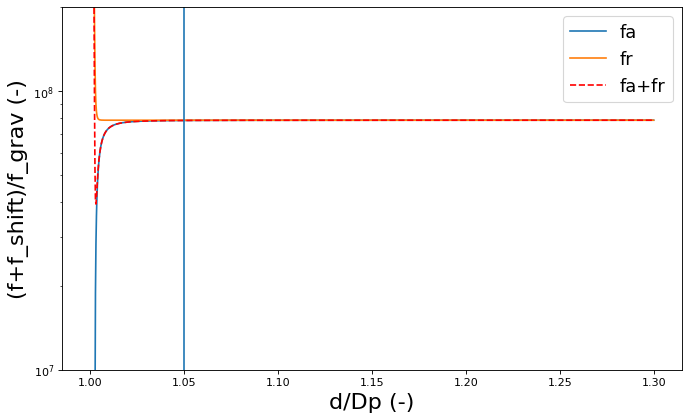

(<matplotlib.legend.Legend at 0x7fc4b92f7040>, None)

In [19]:
def F_atr_point(d, Rp, A):
    f_atr0 = 32.*A/(3.*Rp)
    f_atr1 = pow(Rp / d, 7)
    return f_atr0 * f_atr1

Rp = Dp/2
f_grav = 0.0265402 * (1e-15) *9.81
fact_rep = 1.006

d = np.logspace(np.log10(2.0001),np.log10(2.6),1000) * Rp
fr = np.zeros_like(d)
fa = np.zeros_like(d)
fp = F_atr_point(d, Rp,A)

for i in range(len(d)):
    fr[i] = ftp_model.Rep_interaction(d[i], Rp,Rp,A,s_LJ)*fact_rep
    fa[i] = ftp_model.Attr_interaction(d[i], Rp,Rp,A)

ft = -np.abs(fa)+np.abs(fr)

shift = -2*np.min(ft)

r_ref = 2.10*Rp
fa_ref = ftp_model.Attr_interaction(r_ref, Rp,Rp,A)

print("np.min(ft)/fa_ref= ", np.min(ft/fa_ref), "; fa_ref=", fa_ref)

fig = plt.figure(num=None, figsize=(10, 6), dpi=80, facecolor='w', edgecolor='k');
fig.set_tight_layout(False)
plt.plot(d/Dp, (-fa+shift)/f_grav,"-",label="fa")
plt.plot(d/Dp, (fr+shift)/f_grav,"-",label="fr")
#plt.plot(d/Dp, (-fp+shift)/f_grav,"-",label="fp")
plt.plot(d/Dp, (ft+shift)/f_grav,"--r",label="fa+fr")
plt.yscale("log")
plt.axvline(x=r_ref/Dp)
plt.ylim([1e+07,20e+07])
plt.xlabel("d/Dp (-)",fontsize=20)
plt.ylabel("(f+f_shift)/f_grav (-)",fontsize=20)
plt.legend(fontsize=16, loc=0), plt.show()

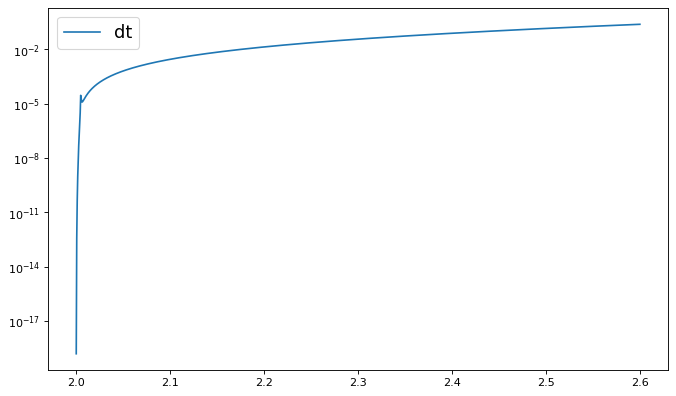

(<matplotlib.legend.Legend at 0x7fc4b9601970>, None)

In [20]:
f_firc = 6.51153e-11
lp = alpha_dp * Dp
dt = lp*f_firc/np.abs(ft)

fig = plt.figure(num=None, figsize=(10, 6), dpi=80, facecolor='w', edgecolor='k');
fig.set_tight_layout(False)
plt.plot(d/Rp, dt/tau,"-",label="dt")
plt.yscale("log")
plt.legend(fontsize=16, loc=0), plt.show()